In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [3]:
erk.bond_price(5, 100, 0.05, 12, 0.03) #coupon rate is 5%, discount rate is 3%, therefore coupon rate is higher than discount rate, so we expect this bond to be priced at a premium

0    109.275393
dtype: float64

In [4]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)

In [8]:
rates[[1,2,3]].head() #first five rows for the first three scenario columns

,1,2,3
0,0.030000,0.030000,0.030000
1,0.031104,0.031745,0.030192
2,0.025694,0.031569,0.031947
3,0.025050,0.031584,0.032742
4,0.023137,0.029756,0.028921


In [5]:
erk.bond_price(5, 100, 0.05, 12, rates.iloc[0][[1,2,3]]) #instead of the constant discount rate of 3%, we use the rates computed above -- first row and first three scenarios

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [6]:
erk.bond_price(5, 100, 0.05, 12, rates.iloc[1][[1,2,3]]) #bond prices at t=1, for first three scenarios

1    108.739692
2    108.429701
3    109.181997
dtype: float64

Now we will amend our code to calculate the bond prices in the erk module. We will have to include the multiple interest rate scenarios in the calculations.

<Axes: >

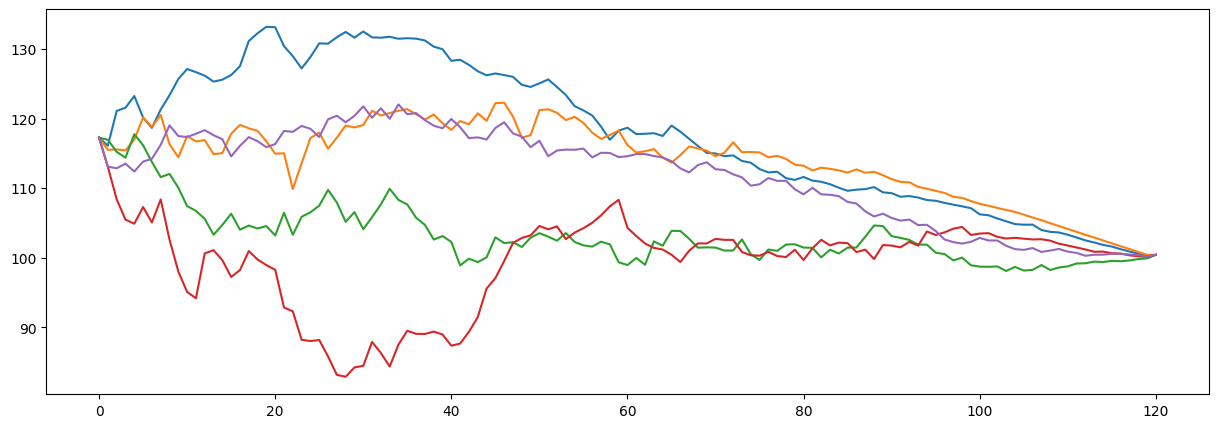

In [10]:
erk.bond_price(10, 100, 0.05, 12, rates[[1,2,3,4,5]]).plot(legend=False, figsize=(15,5))

In [11]:
prices = erk.bond_price(10, 100, 0.05, 12, rates[[1,2,3,4,5]])
prices

,1,2,3,4,5
0,117.260292,117.260292,117.260292,117.260292,117.260292
1,116.106703,115.512898,116.956833,113.052024,113.096008
2,121.100449,115.563358,115.217253,108.397633,112.8572
3,121.563343,115.437143,114.388082,105.478169,113.526364
4,123.248339,116.988093,117.757352,104.891984,112.390105
...,...,...,...,...,...
116,101.22723,101.657452,99.496791,100.598247,100.563907
117,100.893998,101.245174,99.611826,100.347482,100.465253
118,100.591614,100.828648,99.810228,100.204071,100.396
119,100.290602,100.416014,99.910119,100.135673,100.190145


We'll construct the series of bond returns from these prices, and that will help us to model the performance of a portfolio that contains a mix of stocks and bonds. But the price returns by themselves won't do, we have to calculate the total return -- from both the bond price change and the bond coupon payments.

In [12]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
btr = erk.bond_total_return(p, 100, .05, 12)
erk.annualize_rets(btr, 12)

1     0.02756
2    0.028761
3    0.033505
4    0.035581
dtype: object

In [13]:
price_10 = erk.bond_price(10, 100, 0.05, 12, rates) #simulating prices of a 10 year bond for the entire set of scenarios. 'rates' is the interest rates for a period of 10 years
price_10[[1,2,3]].tail()

,1,2,3
116,101.22723,101.657452,99.496791
117,100.893998,101.245174,99.611826
118,100.591614,100.828648,99.810228
119,100.290602,100.416014,99.910119
120,100.416667,100.416667,100.416667


The value of the bond on the final payment date is essentially the value of the final payment

In [14]:
price_30 = erk.bond_price(30, 100, 0.05, 12, rates) #simulating prices of a 30 year bond for the entire set of scenarios. 'rates' is the interest rates for a period of 10 years
price_30[[1,2,3]].tail()

,1,2,3
116,165.879051,200.828493,82.800531
117,163.076004,200.666252,82.446538
118,162.184802,199.986743,86.755224
119,160.465202,200.181142,87.448904
120,153.534267,199.451438,98.777214


In the above result, we see a big difference in the bond prices at the end of 10 years because the bond is 30 year maturity, so there are still another 20 years left to go

In [15]:
rets_30 = erk.bond_total_return(price_30,100, .05, 12)
rets_10 = erk.bond_total_return(price_10,100, .05, 12)
rets_bonds = 0.6*rets_10 + 0.4*rets_30 #assuming that we rebalance the portfolio to 60/40 at the end of each month

In [16]:
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035608,0.00367,0.312701,3.256468,-0.001287,-0.000915,1.487419,0.0


In [18]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [19]:
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [20]:
rets_bonds.shape

(120, 500)

Now we can start combining the equity and bond assets into the multi-asset portfolio.

In [21]:
rets = .70*rets_eq + 0.3*rets_bonds
rets_mean = rets.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.060928,0.004484,0.031749,3.451874,-0.002845,-0.002307,6.713102,0.0
